Notes since sharing : 
- from Zhang et al., 2018 Ten samples (100 ms) beyond the response were also included from each trial in the analysis to ensure that the bump reflecting the motor response was fully captured. 

# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model, all steps are present except the iterative estimation of bumps (only one model is estimated in this notebook) and the LOO-CV procedure. Depending on how things go in your analysis we will add these steps later on.

# Tasks left as exercises :
- Changing sampling frequency can be achieved in cell 3, for now we resample at 100Hz as in the original papers
- bootrstrapping can be achieved usind the resample method : https://xarray.pydata.org/en/stable/generated/xarray.DataArray.resample.html
- PCA is applied from cell 7 to 12, changes should occur there


In [1]:
#Loading required libraries, you should have all of these in the .yml 

import mne
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

The following cells allow you to restrict the analysis to a subset of the participants. THis will ease the computational load on your machine but will be removed for the final analysis

In [2]:
path = '../../supervisions/2022/Bachelor_KI/preprocessed_data/'
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
print(subj_names)
subset = ["S1","S2","S3"]

['S6', 'S18', 'S20', 'S1', 'S16', 'S14', 'S7', 'S15', 'S2', 'S3', 'S4', 'S5', 'S17', 'S10', 'S8', 'S12', 'S9', 'S11', 'S13']


# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [3]:
tmin, tmax = -0.2, 2.2 #window of the trials we are interested in (in seconds)
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213, #conditions in the experiment
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events
epoch_data = [] 
offset_after_resp = 100 #how many milliseconds after response should be stored

if 'epoch_data' not in os.listdir():#avoids to loop again if notebook is restarted
    for participant in subset:
        data = mne.io.read_raw_fif(path+'/preprocessed_%s.fif'%participant, preload=False, verbose=False)
        data.load_data()
        data.filter(.5, 30, fir_design='firwin', verbose=False)#Filtering out frequency outside range .5 and 30Hz, as study by Anderson et al. (Berberyan used 40 Hz)
        # Loading events (in our case one event = one trial)
        events = mne.find_events(data, verbose=False)
        #### @Bruno Here you can use the downsampling feature of MNE, e.g.:
        data, events = data.resample(100, events=events)#100 Hz is the standard used for previous applications of HsMM
        events[:,2] = events[:,2]-events[:,1]#correction on event value


        #Only pick electrodes placed on the scalp:
        picks = mne.pick_types(data.info, eeg=True, stim=False, eog=False, misc=False,
                           exclude='bads') 
        offset_after_resp_samples = int(offset_after_resp/(1000/data.info['sfreq']))
        rts=[]#reaction times
        i = 0 
        while i < len(events):
            if i < len(events)-1 and events[i,2] in event_id.values() \
                and events[i+1,2] in resp_id.values() and events[i-1,2] == 2:#2 for high force condition 
                rts.append(events[i+1,0] - events[i,0] )
            if i < len(events)-1 and events[i,2] in event_id.values() \
                and events[i+1,2] in resp_id.values() and events[i-1,2] ==1:#2 for high force condition 
                rts.append(0)
                
            elif i < len(events)-1 and events[i,2] in event_id.values() and events[i+1,2] not in resp_id.values(): #trials without resp
                rts.append(0)
            elif  i == len(events)-1 and events[i,2] in event_id.values():
                rts.append(0)
            i+= 1
        rts = np.array(rts)
        rts[rts > data.info['sfreq']*2] = 0 #removes RT above 2 sec
        rts[rts < data.info['sfreq']*.3] = 0 #removes RT below 300 ms, important as determines max bumps
        metadata, events, event_id = mne.epochs.make_metadata(
            events=events, event_id= event_id,
            tmin=tmin, tmax=tmax, sfreq=data.info['sfreq'])

        metadata['RT'] = rts 

        epochs = mne.Epochs(data, events, event_id, tmin, tmax, proj=False,
                        picks=picks, baseline=(None, 0), preload=True,
                        verbose=False,detrend=1,on_missing = 'warn',metadata=metadata)
        data_epoch = epochs.get_data()
        cropped_data_epoch = np.empty([len(rts[rts != 0]), len(epochs.ch_names), max(rts)+offset_after_resp_samples])
        cropped_data_epoch[:] = np.nan
        i, j = 0, 0
        for i in np.arange(len(data_epoch)):
            if rts[i] != 0:
            #Crops the epochs to time 0 (stim onset) up to RT
                cropped_data_epoch[j,:,:rts[i]+offset_after_resp_samples] = (data_epoch[i,:,epochs.time_as_index(0)[0]:
                                    epochs.time_as_index(0)[0]+int(rts[i])+offset_after_resp_samples])
                j += 1

        # recover actual data points in a 3D matrix with dimensions trials X electrodes X sample
        epoch_data.append(xr.Dataset(
            {
                "data": (["epochs", "electrodes", "samples"],cropped_data_epoch),
                "RT": (["epochs"], rts[rts != 0]),
            },
            coords={
                "epochs" : np.arange(len(cropped_data_epoch)),
                "electrodes":  epochs.ch_names,
                # TODO When time "electrodes": (['name','x','y','z'], epochs.ch_names,
                "samples": np.arange(max(rts)+offset_after_resp_samples)#+1)
            },
            attrs={'sfreq':epochs.info['sfreq']}
            )
        )

    epoch_data = xr.concat(epoch_data, dim="participant")
    epoch_data.coords['participant'] =  subset
    epoch_data.to_netcdf('epoch_data.nc')
else: 
    epoch_data = xr.open_dataset('epoch_data.nc')

Reading 0 ... 6117375  =      0.000 ...  5973.999 secs...


/tmp/ipykernel_710588/769917507.py:10: RuntimeWarning: This filename (../../supervisions/2022/Bachelor_KI/preprocessed_data//preprocessed_S1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif(path+'/preprocessed_%s.fif'%participant, preload=False, verbose=False)
/tmp/ipykernel_710588/769917507.py:10: RuntimeWarning: This filename (../../supervisions/2022/Bachelor_KI/preprocessed_data//preprocessed_S2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif(path+'/preprocessed_%s.fif'%participant, preload=False, verbose=False)


Reading 0 ... 5378047  =      0.000 ...  5251.999 secs...


/tmp/ipykernel_710588/769917507.py:10: RuntimeWarning: This filename (../../supervisions/2022/Bachelor_KI/preprocessed_data//preprocessed_S3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif(path+'/preprocessed_%s.fif'%participant, preload=False, verbose=False)


Reading 0 ... 4689919  =      0.000 ...  4579.999 secs...


Here is an example of how to manipulate xarray objects, I here plot the activity of two electrodes (Fpz and Cz, see https://www.biosemi.com/pics/cap_64_layout_medium.jpg for the positions of those electrodes), over the first trial (epoch = 0) for participant 1

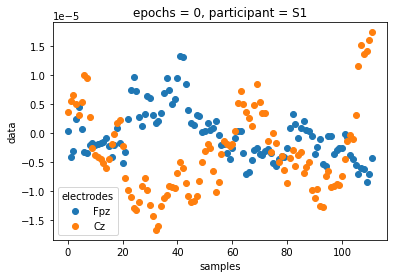

In [4]:
#example of usage of xarray
epoch_data.sel(epochs=0,electrodes=['Fpz','Cz'],participant=subset[0]).plot.scatter(x='samples', y='data',hue='electrodes')

Or we can also look at the grand average:

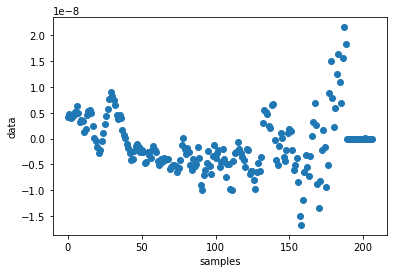

In [5]:
#example of usage of xarray
epoch_data.mean(dim=["epochs","participant","electrodes"]).plot.scatter(x='samples', y='data')

## Scaling variances to mean variance of the group

First processing step for the PCA is to scale individual variances to the group variance.

In [6]:
mean_std = epoch_data.groupby('participant').std(dim=...).data.mean()
epoch_data = epoch_data.assign(mean_std=mean_std.data)

In [7]:
def standardize(x):
    return ((x.data / x.data.std(dim=...)*x.mean_std))
var_scaled = epoch_data.groupby('participant').map(standardize)

## Computing cov matrices by trial and take the average of those

In [8]:
def vcov_mat(x):
    x = x.dropna(dim="samples").squeeze().data
    xT = x.T.data
    return x @ xT

In [9]:
var_cov_matrices = []
for i,trial_dat in var_scaled.stack(trial=("participant", "epochs")).groupby('trial'):
    var_cov_matrices.append(vcov_mat(trial_dat)) #Would be nice not to have a for loop but groupby.map seem to fal

In [10]:
average_var_cov_matrix = np.mean(var_cov_matrices,axis=0)

## Performing spatial PCA on the average var-cov matrix

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, svd_solver='arpack')#selecting 10 Principale components (PC)
pca_data = pca.fit_transform(average_var_cov_matrix)

#Rebuilding pca PCs as xarray to ease computation
coords = dict(electrodes=("electrodes", var_scaled.coords["electrodes"].values),
             compoment=("component", np.arange(10)))
pca_data = xr.DataArray(pca_data, dims=("electrodes","component"), coords=coords)
data = var_scaled @ pca_data

z-scoring the PCs by trial

In [ ]:
def zscore(x):
    data = x
    return (data - data.mean()) / data.std()
z_scored = data.stack(trial=["participant",'epochs','component']).groupby('trial').map(zscore).unstack()

Plotting to show the  time series of the components

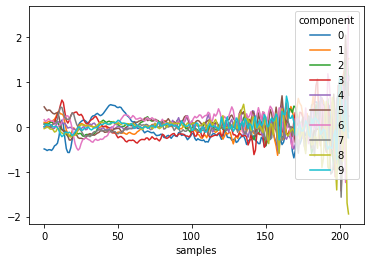

In [13]:
z_scored.mean(dim=["participant",'epochs']).plot.line(x='samples', hue="component");

Note for self : normalization might not be correct, TOCHECK

# Applying HsMM

In [14]:
import pyhsmm_mvpa as hsmm

this part is rather not very pythonic because it is adapted from matlab

In [15]:
stacked = z_scored.stack(all_samples=["participant",'epochs',"samples"]).dropna(dim="all_samples")

In [16]:
stacked

<xarray.DataArray (component: 10, all_samples: 110984)>
array([[-0.36392827,  0.63434395,  0.00860322, ...,  0.12175129,
        -0.04053318, -0.50214   ],
       [ 0.23812876, -0.85576743, -1.15443583, ..., -0.02314973,
         0.70327782,  0.59073312],
       [-1.88994959, -0.27837741,  0.95328984, ...,  0.58314248,
         1.40815833,  1.49625223],
       ...,
       [-1.24838331,  0.00320691, -0.16315857, ..., -1.25979865,
        -0.48516305, -0.92147534],
       [ 0.41718205,  0.62991549,  0.77138198, ...,  0.57742462,
         0.15559093,  0.47582599],
       [ 0.26531202,  0.09231837, -0.29965445, ..., -1.17280089,
        -1.03965151,  0.42977178]])
Coordinates:
    compoment    (component, all_samples) int64 0 0 0 0 0 0 0 ... 9 9 9 9 9 9 9
  * component    (component) int64 0 1 2 3 4 5 6 7 8 9
  * all_samples  (all_samples) MultiIndex
  - participant  (all_samples) object 'S1' 'S1' 'S1' 'S1' ... 'S3' 'S3' 'S3'
  - epochs       (all_samples) int64 0 0 0 0 0 0 0 ... 607 607 607 607 607 607
  - samples      (all_samples) int64 0 1 2 3 4 5 6 ... 131 132 133 134 135 136

Extract durations of epochs (equivalent to RTs) to partition the stacked data

In [17]:
durations = np.unique(epoch_data.stack(trial=["participant",'epochs']).reset_index(["participant",'epochs']).groupby('trial').count(dim="samples").sel(electrodes="Fpz").data.cumsum().to_numpy())
starts = np.insert(durations[:-1],0,0)
ends = durations-1
print(starts)
print(ends)

[     0    112    219 ... 110619 110735 110847]
[   111    218    303 ... 110734 110846 110983]


In [18]:
init = hsmm.hsmm(stacked.to_numpy().T, starts, ends, sf=epoch_data.sfreq)

Estimating a 3 bump model (solution found for a similar experiment https://link.springer.com/article/10.1007/s42113-021-00105-2). Later one we will work on model selection for the number of bumps but that is not important for now.

In [19]:
#debugging tool, reloads when files are changed
%load_ext autoreload 
%autoreload 2

In [20]:
bump3_estimates = init.fit_single(3)

Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 3 bumps model


In [21]:
bump3_estimates

<xarray.Dataset>
Dimensions:      (stage: 9, params: 2, component: 10, bump: 8, samples: 207,
                  trial: 1418)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -4.757e+03
    parameters   (stage, params) float64 2.0 2.72 2.0 7.258 ... nan nan nan nan
    magnitudes   (component, bump) float64 -0.8773 -0.3954 1.145 ... nan nan nan
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 nan ... nan nan nan

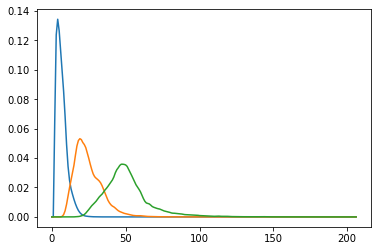

In [22]:
plt.plot(bump3_estimates.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2]))

(0.0, 600.0)

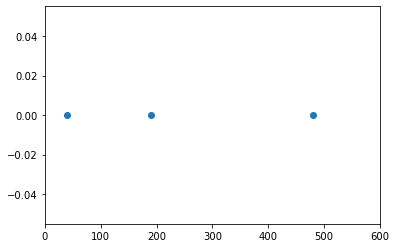

In [23]:
plt.plot(init.mean_bump_times(bump3_estimates), np.repeat(0,3),'o')
plt.xlim(0,600)